Importing Libraries

In [1]:
import pandas as pd
from utils import *
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2


Read the data

In [3]:
stock_name = 'IBM'
source = 'alphavantage'

In [5]:
alpha_df = pd.read_csv(f'Data/{stock_name}/{stock_name}_data_{source}.csv', index_col=0)
alpha_df.index = pd.to_datetime(alpha_df.index)
alpha_df = alpha_df.rename(columns={'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. volume': 'volume'})
transform_to_float(alpha_df)
alpha_df.head()

,open,high,low,close,volume
2000-01-03 09:40:00,58.635,58.940,58.082,58.394,377606.0
2000-01-03 09:45:00,58.505,59.268,58.050,58.817,1105831.0
2000-01-03 09:50:00,58.929,59.202,58.179,58.622,376769.0
2000-01-03 09:55:00,58.570,59.169,58.179,58.492,159724.0
2000-01-03 10:00:00,58.570,59.202,58.179,58.590,222170.0


Data Analysis

Calculating daily returns

In [6]:
import pandas as pd
import numpy as np

# Resample DataFrame to daily frequency and keep only the last row in each day
daily_data = alpha_df.resample('D').agg({'close': 'last', 'volume': 'sum'}) 

daily_data['return'] = np.log(daily_data['close'] / daily_data['close'].shift(1))

daily_data.dropna(inplace=True)

daily_data.head()

,close,volume,return
2000-01-04,58.362,8440139.0,-0.030758
2000-01-05,60.412,13093899.0,0.034523
2000-01-06,59.371,8161798.0,-0.017382
2000-01-07,59.013,12143503.0,-0.006048
2000-01-11,61.975,8053122.0,0.008442


In [7]:
daily_data['return'].mean()

-4.408991523290699e-06

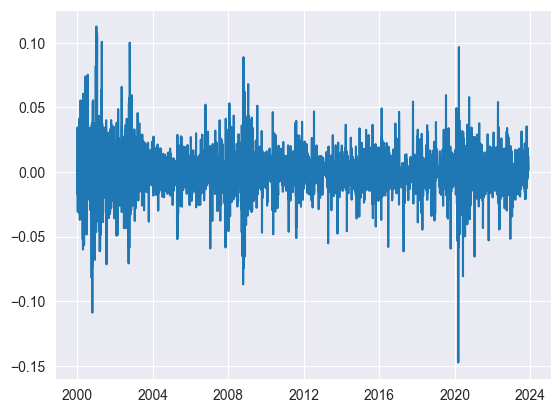

In [8]:
# plot the returns
plt.plot(daily_data['return'])

In [9]:
daily_data.describe()

,close,volume,return
count,4572.000000,4.572000e+03,4572.000000
mean,84.251499,5.969549e+06,-0.000004
std,30.305720,3.540321e+06,0.016116
min,29.207000,1.004020e+06,-0.147399
25%,53.267500,3.537172e+06,-0.007326
50%,91.190500,5.089100e+06,0.000149
75%,110.392500,7.324148e+06,0.007574
max,156.897000,3.456625e+07,0.112576


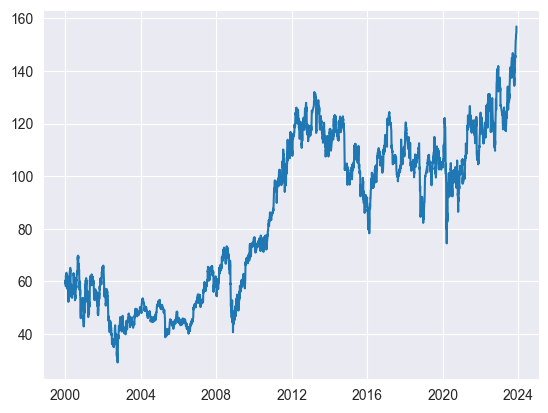

In [10]:
plt.plot(daily_data['close'])

Test 1: Stationarity Test (Augmented Dickey-Fuller Test) on returns

In [11]:
stationarity_test(daily_data['return'])

ADF Statistic: -68.958209
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Test 2: Autocorrelation with Ljung-Box Test. 

In [12]:
Ljung_Box_Test(daily_data['return'], 15)

,lb_stat,lb_pvalue
1,1.763583,0.184178
2,2.816200,0.244608
3,2.824297,0.419516
4,4.088569,0.394152
5,6.136514,0.293161
6,6.575044,0.361939
7,6.891985,0.440212
8,7.198839,0.515339
9,12.848995,0.169559
10,12.854743,0.231907


Since none of the lags are significant for the returns, we can assume that the returns are not autocorrelated (This is also equivalent that the residuals are not autocorrelated and they are i.i.d) So we should not use AR models for the returns. And also the assumption of i.i.d residuals which is the assumption of GARCH model is satisfied.

In [13]:
daily_data['residuals'] = daily_data['return'] - daily_data['return'].mean()
# Calculate squared returns
daily_data['residuals^2'] = daily_data['residuals'] ** 2

# Print test statistics and p-values
Ljung_Box_Test(daily_data['residuals^2'], 15)

,lb_stat,lb_pvalue
1,189.359116,4.387564e-43
2,303.636508,1.164582e-66
3,384.094875,6.167983e-83
4,548.303517,2.382190e-117
5,645.839608,2.510340e-137
6,943.204069,1.713176e-200
7,1120.619367,1.028085e-237
8,1321.209596,6.118278e-280
9,1400.044689,7.561009e-296
10,1487.338476,0.000000e+00


Autocorrelation test for GARCH. If we have that Y_t = mu + epsilon_t, then in GARCH we have that epsilon_t = sigma_t * z_t, where z_t is i.i.d. and sigma_t is the conditional volatility, Since we assume the mean of epsilon_t is zero, the variance is epsilon_t^2. So we have to have that the squared residuals are autocorrelated. This is a proof of heteroscedasticity.

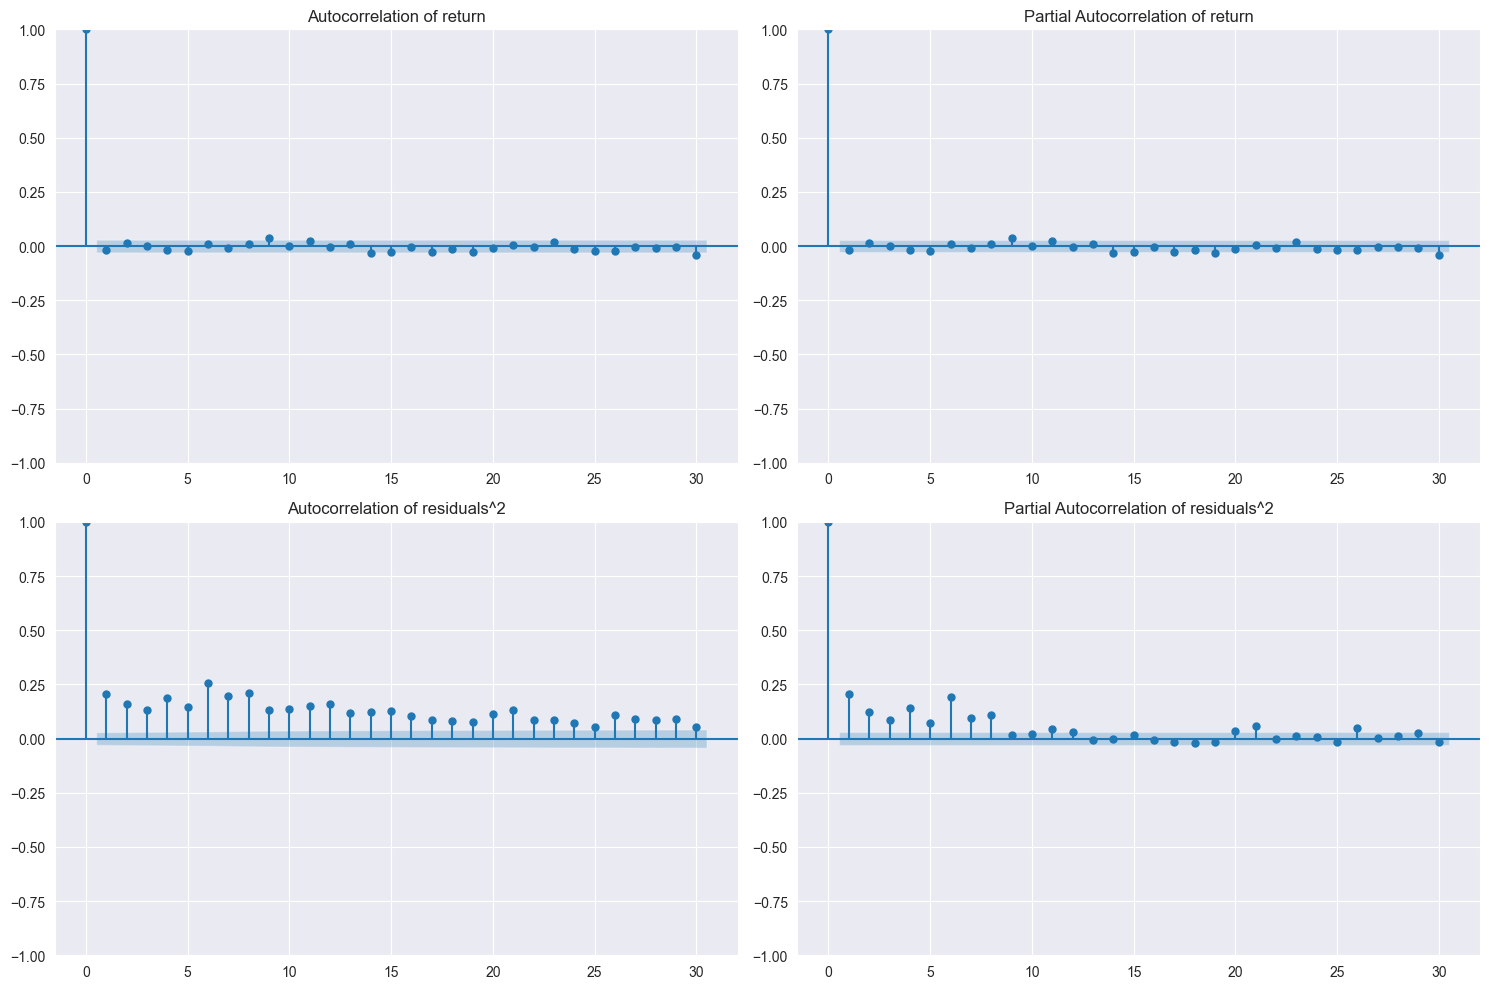

In [14]:
plot_autocorrelations(['return', 'residuals^2'], [daily_data['return'], daily_data['residuals^2']])


Since the returns are clearly not autocorrelated, we would use Y_t = mu + epsilon_t and we see later that the mu ~= 0

GARCH Model

In [15]:
import importlib
import vol_models

importlib.reload(vol_models)
from vol_models import GARCHModel

Iteration:      1,   Func. Count:      6,   Neg. LLF: 29589.178298315644
Iteration:      2,   Func. Count:     16,   Neg. LLF: 504304.1741536228
Iteration:      3,   Func. Count:     25,   Neg. LLF: 9551.401485565066
Iteration:      4,   Func. Count:     32,   Neg. LLF: 9100.247240924273
Iteration:      5,   Func. Count:     39,   Neg. LLF: 8026.6192912689
Iteration:      6,   Func. Count:     45,   Neg. LLF: 7996.968412498811
Iteration:      7,   Func. Count:     50,   Neg. LLF: 7996.901377787433
Iteration:      8,   Func. Count:     55,   Neg. LLF: 7996.886026062105
Iteration:      9,   Func. Count:     60,   Neg. LLF: 7996.88595649449
Iteration:     10,   Func. Count:     64,   Neg. LLF: 7996.885956493841
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7996.88595649449
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results                  

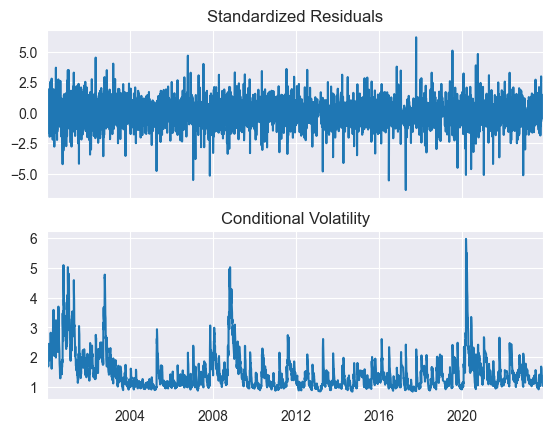

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#TODO: whether I should pass the residuals or the returns to garch model

daily_data['returns*100'] = daily_data['return'] * 100

garch_1_1 = GARCHModel(1,1)
# Fit a GARCH(1,1) model
garch_1_1.fit_garch_model(daily_data['returns*100'])
garch_1_1.plot_results()

standardized residuals are Y_t - mu / sigma_t which have to i.i.d

Tesing for autocorrelation of standardized residuals. Residuals are i.i.d : There should be no autocorrelation in the residuals

In [36]:
std_resid = garch_1_1.resid / garch_1_1.conditional_volatility
Ljung_Box_Test(std_resid, 15)

,lb_stat,lb_pvalue
1,0.013208,0.908503
2,0.114419,0.944396
3,0.156314,0.984313
4,1.802413,0.772041
5,2.588036,0.763182
6,2.591694,0.858068
7,4.247372,0.750885
8,4.690997,0.790034
9,6.533053,0.685608
10,7.007299,0.724756


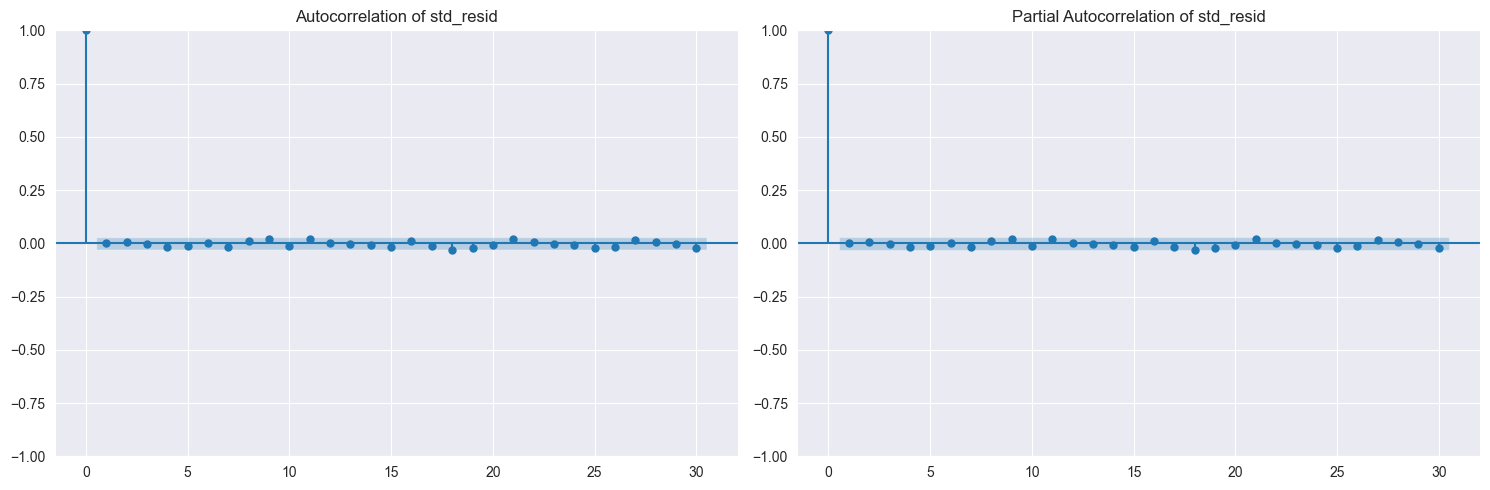

In [37]:
plot_autocorrelations(['std_resid'], [std_resid])

Arch effect test: The squared residuals should be correlated

In [38]:
garch_1_1.EngleArchTest_()

Test results: (631.191207569321, 3.6341692381076544e-129, 73.07786609156561, 2.8481032586864175e-139)


In [39]:
Ljung_Box_Test(garch_1_1.resid ** 2, 15)

,lb_stat,lb_pvalue
1,189.124884,4.935739e-43
2,303.671593,1.144330e-66
3,384.594947,4.806567e-83
4,550.254942,9.010878e-118
5,648.944898,5.352327e-138
6,945.729509,4.872224e-201
7,1121.811581,5.679309e-238
8,1323.797389,1.687496e-280
9,1403.650452,1.257484e-296
10,1491.177605,0.000000e+00


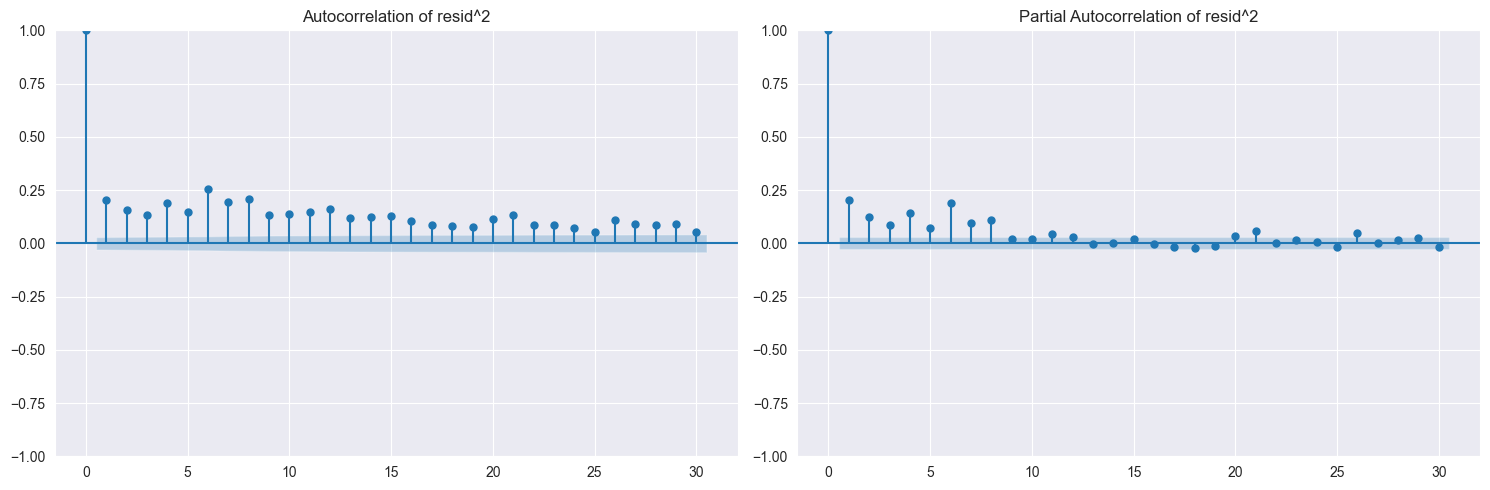

In [40]:
plot_autocorrelations(['resid^2'], [garch_1_1.resid ** 2])


Check the normality of the standardized residuals

Skewness: -0.17939554165517788 Skewness of a normal distribution is 0.
Kurtosis: 3.2896612092599016 Kurtosis of a normal distribution is 3.
Shapiro-Wilk Test p-value: 8.37998826034537e-31
The data significantly deviates from a normal distribution.


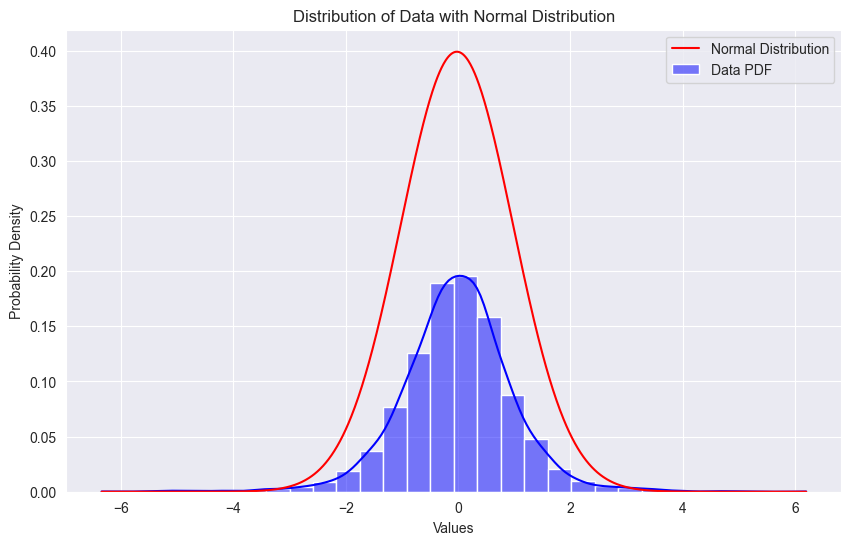

In [41]:
check_normality(std_resid)

Hyperparameter search. We don't use log likelihood because it doesn't take into account the number of parameters in the model. We use AIC and BIC instead.

In [42]:
import numpy as np
from arch import arch_model

# Assuming 'daily_data' is your DataFrame and 'residuals' is the column you want to model
# Define the range of values for p and q
p_values = range(1, 7)
q_values = range(1, 7)

# Define the distributions
distributions = ['normal', 't', 'skewt']

# Initialize variables to store the best results
best_bic = np.inf
best_aic = np.inf
best_model_bic = None
best_model_aic = None

# Iterate over all combinations of p, q, and distribution
for dist in distributions:
    for p in p_values:
        for q in q_values:
            # Fit the GARCH model
            garch_model = GARCHModel(p,q, dist = dist)
            garch_model.fit_garch_model(daily_data['returns*100'], disp = 'off')
            # Get BIC, AIC
            bic = garch_model.result.bic
            aic = garch_model.result.aic

            # Update the best BIC model
            if bic < best_bic:
                best_bic = bic
                best_model_bic = [p,q]

            # Update the best AIC model
            if aic < best_aic:
                best_aic = aic
                best_model_aic = [p,q]


    # Print the best models
    print(f"Best BIC model for {dist}:", best_model_bic)
    print(f"Best AIC model for {dist}:", best_model_aic)

Best BIC model for normal: [1, 1]
Best AIC model for normal: [1, 2]
Best BIC model for t: [1, 1]
Best AIC model for t: [1, 4]
Best BIC model for skewt: [1, 1]
Best AIC model for skewt: [1, 4]


In [43]:
import numpy as np
from arch import arch_model

# Define the distributions
distributions = ['normal', 't', 'skewt']

# Initialize variables to store the best results
best_bic = np.inf
best_aic = np.inf
best_dist_bic = None
best_dist_aic = None

# Iterate over all distributions
for dist in distributions:
    # Fit the GARCH model
    garch_model = GARCHModel(1,1, dist = dist)
    garch_model.fit_garch_model(daily_data['returns*100'], disp = 'off')
    # Get BIC, AIC, and log-likelihood
    bic = garch_model.result.bic
    aic = garch_model.result.aic

    # Update the best BIC distribution
    if bic < best_bic:
        best_bic = bic
        best_dist_bic = dist

    # Update the best AIC distribution
    if aic < best_aic:
        best_aic = aic
        best_dist_aic = dist


# Print the best distributions
print(f"Best BIC distribution: {best_dist_bic}")
print(f"Best AIC distribution: {best_dist_aic}")

Best BIC distribution: t
Best AIC distribution: t


Until here we decide that the best distribution is the t distribution

Iteration:      1,   Func. Count:      7,   Neg. LLF: 122378.06426903192
Iteration:      2,   Func. Count:     17,   Neg. LLF: 74436.96154135857
Iteration:      3,   Func. Count:     26,   Neg. LLF: 12561.24243582831
Iteration:      4,   Func. Count:     35,   Neg. LLF: 13146.175485821677
Iteration:      5,   Func. Count:     43,   Neg. LLF: 11680.493432036217
Iteration:      6,   Func. Count:     50,   Neg. LLF: 7772.411899190567
Iteration:      7,   Func. Count:     56,   Neg. LLF: 7772.295445131817
Iteration:      8,   Func. Count:     62,   Neg. LLF: 7772.2767715696045
Iteration:      9,   Func. Count:     68,   Neg. LLF: 7772.273734411503
Iteration:     10,   Func. Count:     74,   Neg. LLF: 7772.273571289802
Iteration:     11,   Func. Count:     80,   Neg. LLF: 7772.273562586742
Iteration:     12,   Func. Count:     85,   Neg. LLF: 7772.27356258674
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7772.273562586742
            Iterations: 1

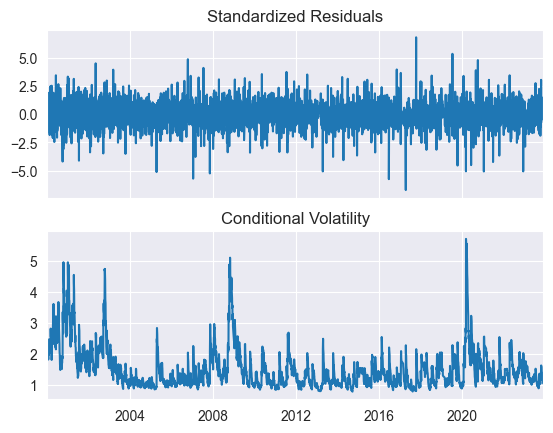

In [45]:
garch_1_1_t = GARCHModel(1,1, dist = 't')
garch_1_1_t.fit_garch_model(daily_data['returns*100'])
garch_1_1_t.plot_results()

Tesing for autocorrelation of standardized residuals

In [46]:
std_resid = garch_1_1_t.resid / garch_1_1_t.conditional_volatility
Ljung_Box_Test(std_resid, 15)

,lb_stat,lb_pvalue
1,0.062738,0.802220
2,0.196296,0.906515
3,0.210330,0.975905
4,1.922352,0.750038
5,2.650908,0.753616
6,2.651126,0.851186
7,4.451733,0.726521
8,5.024485,0.754956
9,6.884786,0.649114
10,7.460101,0.681411


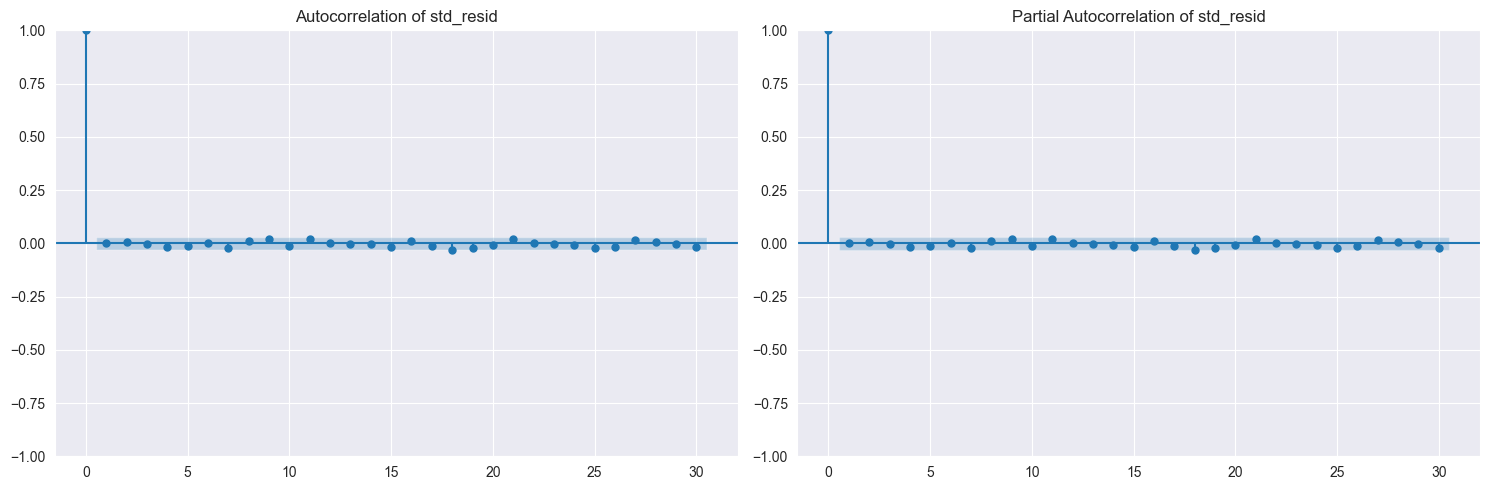

In [47]:
plot_autocorrelations(['std_resid'], [std_resid])

Arch effect test: The squared residuals should be correlated

In [48]:
garch_1_1_t.EngleArchTest_()

Test results: (631.0769182352119, 3.8451137018973946e-129, 73.06250962303365, 3.040709992869806e-139)


In [49]:
Ljung_Box_Test(garch_1_1_t.resid ** 2, 15)

,lb_stat,lb_pvalue
1,189.198841,4.755637e-43
2,303.674932,1.142421e-66
3,384.472109,5.110225e-83
4,549.735089,1.167462e-117
5,648.107954,8.117917e-138
6,945.065982,6.779568e-201
7,1121.526422,6.545478e-238
8,1323.131488,2.350643e-280
9,1402.703019,2.014698e-296
10,1490.168854,0.000000e+00


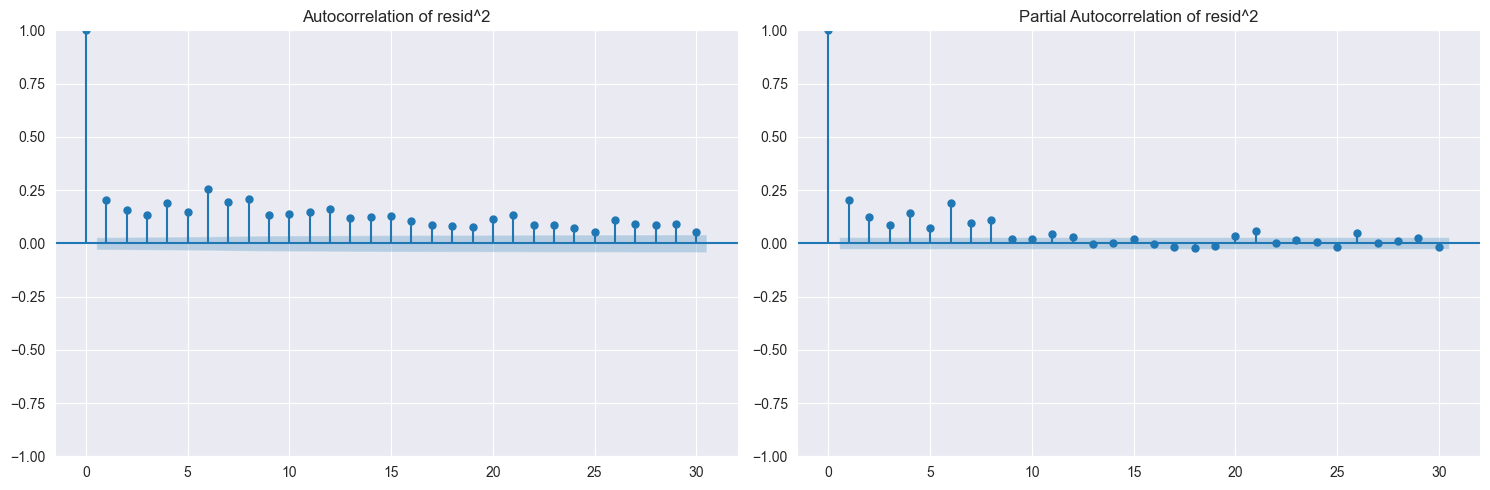

In [50]:
plot_autocorrelations(['resid^2'], [garch_1_1_t.resid ** 2])


Check the t distribution of the standardized residuals

In [51]:
check_t_distribution(std_resid)

KS-statistic: 0.009083752601322104
P-value: 0.8414918082659333
The standardized residuals could be from a t-distribution.


Forecasting volatility

Calculating the daily log returns and realized volatility

In [32]:
# TODO: Take care of outliers

import pandas as pd
import numpy as np
# Assuming df is your DataFrame with the "close" column

# Calculate log returns
alpha_df['return'] = np.log(alpha_df['close'] / alpha_df['close'].shift(1))

In [33]:
alpha_df.head()

,open,high,low,close,volume,return
2000-01-03 09:40:00,58.635,58.940,58.082,58.394,377606.0,NaN
2000-01-03 09:45:00,58.505,59.268,58.050,58.817,1105831.0,0.007218
2000-01-03 09:50:00,58.929,59.202,58.179,58.622,376769.0,-0.003321
2000-01-03 09:55:00,58.570,59.169,58.179,58.492,159724.0,-0.002220
2000-01-03 10:00:00,58.570,59.202,58.179,58.590,222170.0,0.001674


In [ ]:
# TODO: check the gaps in data

In [91]:
# Calculate sum of squared returns and sum of volume for each day
data = alpha_df.resample('D').agg({'return': lambda x: (x**2).sum(), 'volume': 'sum'})

data = data.loc[np.unique(alpha_df.index.date)]


data = data[['return', 'volume']]
# Rename the columns
data.rename(columns={'return': 'rv5'}, inplace=True)

# Take the square root of the 'rv5' column
data['rv5'] = np.sqrt(data['rv5'])

# Print the resulting DataFrame
print(data)

                 rv5      volume
2000-01-03  0.027217  10418229.0
2000-01-04  0.025932   8440139.0
2000-01-05  0.042610  13093899.0
2000-01-06  0.040542   8161798.0
2000-01-07  0.038136  12143503.0
...              ...         ...
2023-11-24  0.007200   2805020.0
2023-11-27  0.012142   5822439.0
2023-11-28  0.009585   4841938.0
2023-11-29  0.008933   5155976.0
2023-11-30  0.011548  15775534.0

[5846 rows x 2 columns]


In [92]:
data.head()

,rv5,volume
2000-01-03,0.027217,10418229.0
2000-01-04,0.025932,8440139.0
2000-01-05,0.042610,13093899.0
2000-01-06,0.040542,8161798.0
2000-01-07,0.038136,12143503.0


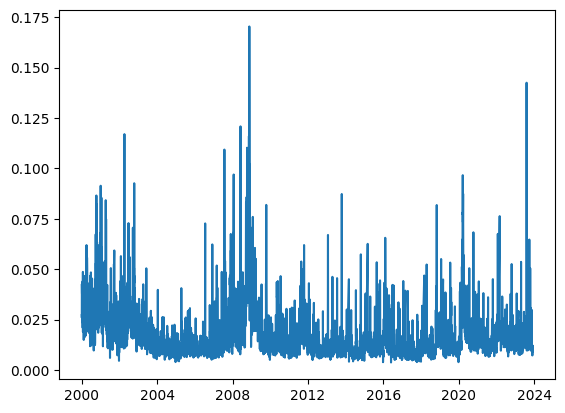

In [93]:
plt.plot(data['rv5'])


Add the indicators to the dataframe

In [94]:
ADS = pd.read_csv('Data/Indicators/ADS Index.csv', index_col=0)
ADS.columns

Index([], dtype='object')

In [95]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('Data/Indicators/ADS Index.csv', sep=';', index_col=0)

# Rename the column
df.columns = ['ADS']

# Convert the index to datetime
df.index = pd.to_datetime(df.index, format='%Y:%m:%d')

# Assuming 'data' is your other DataFrame and both 'data' and 'df' have a common column for merging
data = data.merge(df, left_index=True, right_index=True, how='inner')
# Print the DataFrame
data.head()

,rv5,volume,ADS
2000-01-03,0.027217,10418229.0,0.391972
2000-01-04,0.025932,8440139.0,0.373382
2000-01-05,0.042610,13093899.0,0.355170
2000-01-06,0.040542,8161798.0,0.337332
2000-01-07,0.038136,12143503.0,0.319858


In [96]:
df = pd.read_csv('Data/Indicators/Economic Policy Index.csv', index_col=0)

df.index = pd.to_datetime(df.index)

data = data.merge(df, left_index=True, right_index=True, how='inner')

data.head()

,rv5,volume,ADS,USEPUINDXD
2000-01-03,0.027217,10418229.0,0.391972,35.73
2000-01-04,0.025932,8440139.0,0.373382,109.31
2000-01-05,0.042610,13093899.0,0.355170,123.22
2000-01-06,0.040542,8161798.0,0.337332,53.61
2000-01-07,0.038136,12143503.0,0.319858,42.03


In [97]:
df = pd.read_csv('Data/Indicators/Treasury Indexes.csv', index_col=0)

df.index = pd.to_datetime(df.index)

data = data.merge(df, left_index=True, right_index=True, how='left')

data.head()

,rv5,volume,ADS,USEPUINDXD,b30ret,b30ind,b20ret,b20ind,b10ret,b10ind,...,b2ret,b2ind,b1ret,b1ind,t90ret,t90ind,t30ret,t30ind,cpiret,cpiind
2000-01-03,0.027217,10418229.0,0.391972,35.73,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,0.025932,8440139.0,0.373382,109.31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,0.042610,13093899.0,0.355170,123.22,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,0.040542,8161798.0,0.337332,53.61,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,0.038136,12143503.0,0.319858,42.03,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
data.ffill(inplace=True)
data.dropna(inplace=True)
data.head()

,rv5,volume,ADS,USEPUINDXD,b30ret,b30ind,b20ret,b20ind,b10ret,b10ind,...,b2ret,b2ind,b1ret,b1ind,t90ret,t90ind,t30ret,t30ind,cpiret,cpiind
2000-01-31,0.026414,6347414.0,-0.221090,55.95,0.004485,809.1886,0.017036,950.9799,-0.009797,929.3236,...,-0.001417,854.6951,0.002476,851.9045,0.004339,720.8893,0.004343,608.6602,0.002971,397.2
2000-02-01,0.024440,7561185.0,-0.246874,46.63,0.004485,809.1886,0.017036,950.9799,-0.009797,929.3236,...,-0.001417,854.6951,0.002476,851.9045,0.004339,720.8893,0.004343,608.6602,0.002971,397.2
2000-02-02,0.035782,7910656.0,-0.269239,58.44,0.004485,809.1886,0.017036,950.9799,-0.009797,929.3236,...,-0.001417,854.6951,0.002476,851.9045,0.004339,720.8893,0.004343,608.6602,0.002971,397.2
2000-02-03,0.021713,6444790.0,-0.288193,31.15,0.004485,809.1886,0.017036,950.9799,-0.009797,929.3236,...,-0.001417,854.6951,0.002476,851.9045,0.004339,720.8893,0.004343,608.6602,0.002971,397.2
2000-02-04,0.020219,5612908.0,-0.303742,77.90,0.004485,809.1886,0.017036,950.9799,-0.009797,929.3236,...,-0.001417,854.6951,0.002476,851.9045,0.004339,720.8893,0.004343,608.6602,0.002971,397.2


In [99]:
import yfinance as yf
import pandas as pd

# Download VIX data from Yahoo Finance
vix = yf.download('^VIX', start='2000-01-01', end='2024-12-31')

# Convert the index to datetime
vix.index = pd.to_datetime(vix.index)

vix = vix[['Close']].rename(columns={'Close': 'VIX'})
# Merge the VIX data with your existing dataframe
# Assuming 'data' is your existing dataframe
data = data.merge(vix, left_index=True, right_index=True, how='left')
data.head()

[*********************100%%**********************]  1 of 1 completed


,rv5,volume,ADS,USEPUINDXD,b30ret,b30ind,b20ret,b20ind,b10ret,b10ind,...,b2ind,b1ret,b1ind,t90ret,t90ind,t30ret,t30ind,cpiret,cpiind,VIX
2000-01-31,0.026414,6347414.0,-0.221090,55.95,0.004485,809.1886,0.017036,950.9799,-0.009797,929.3236,...,854.6951,0.002476,851.9045,0.004339,720.8893,0.004343,608.6602,0.002971,397.2,24.950001
2000-02-01,0.024440,7561185.0,-0.246874,46.63,0.004485,809.1886,0.017036,950.9799,-0.009797,929.3236,...,854.6951,0.002476,851.9045,0.004339,720.8893,0.004343,608.6602,0.002971,397.2,23.450001
2000-02-02,0.035782,7910656.0,-0.269239,58.44,0.004485,809.1886,0.017036,950.9799,-0.009797,929.3236,...,854.6951,0.002476,851.9045,0.004339,720.8893,0.004343,608.6602,0.002971,397.2,23.120001
2000-02-03,0.021713,6444790.0,-0.288193,31.15,0.004485,809.1886,0.017036,950.9799,-0.009797,929.3236,...,854.6951,0.002476,851.9045,0.004339,720.8893,0.004343,608.6602,0.002971,397.2,22.010000
2000-02-04,0.020219,5612908.0,-0.303742,77.90,0.004485,809.1886,0.017036,950.9799,-0.009797,929.3236,...,854.6951,0.002476,851.9045,0.004339,720.8893,0.004343,608.6602,0.002971,397.2,21.540001


Data Analysis and Visualization

<Axes: >

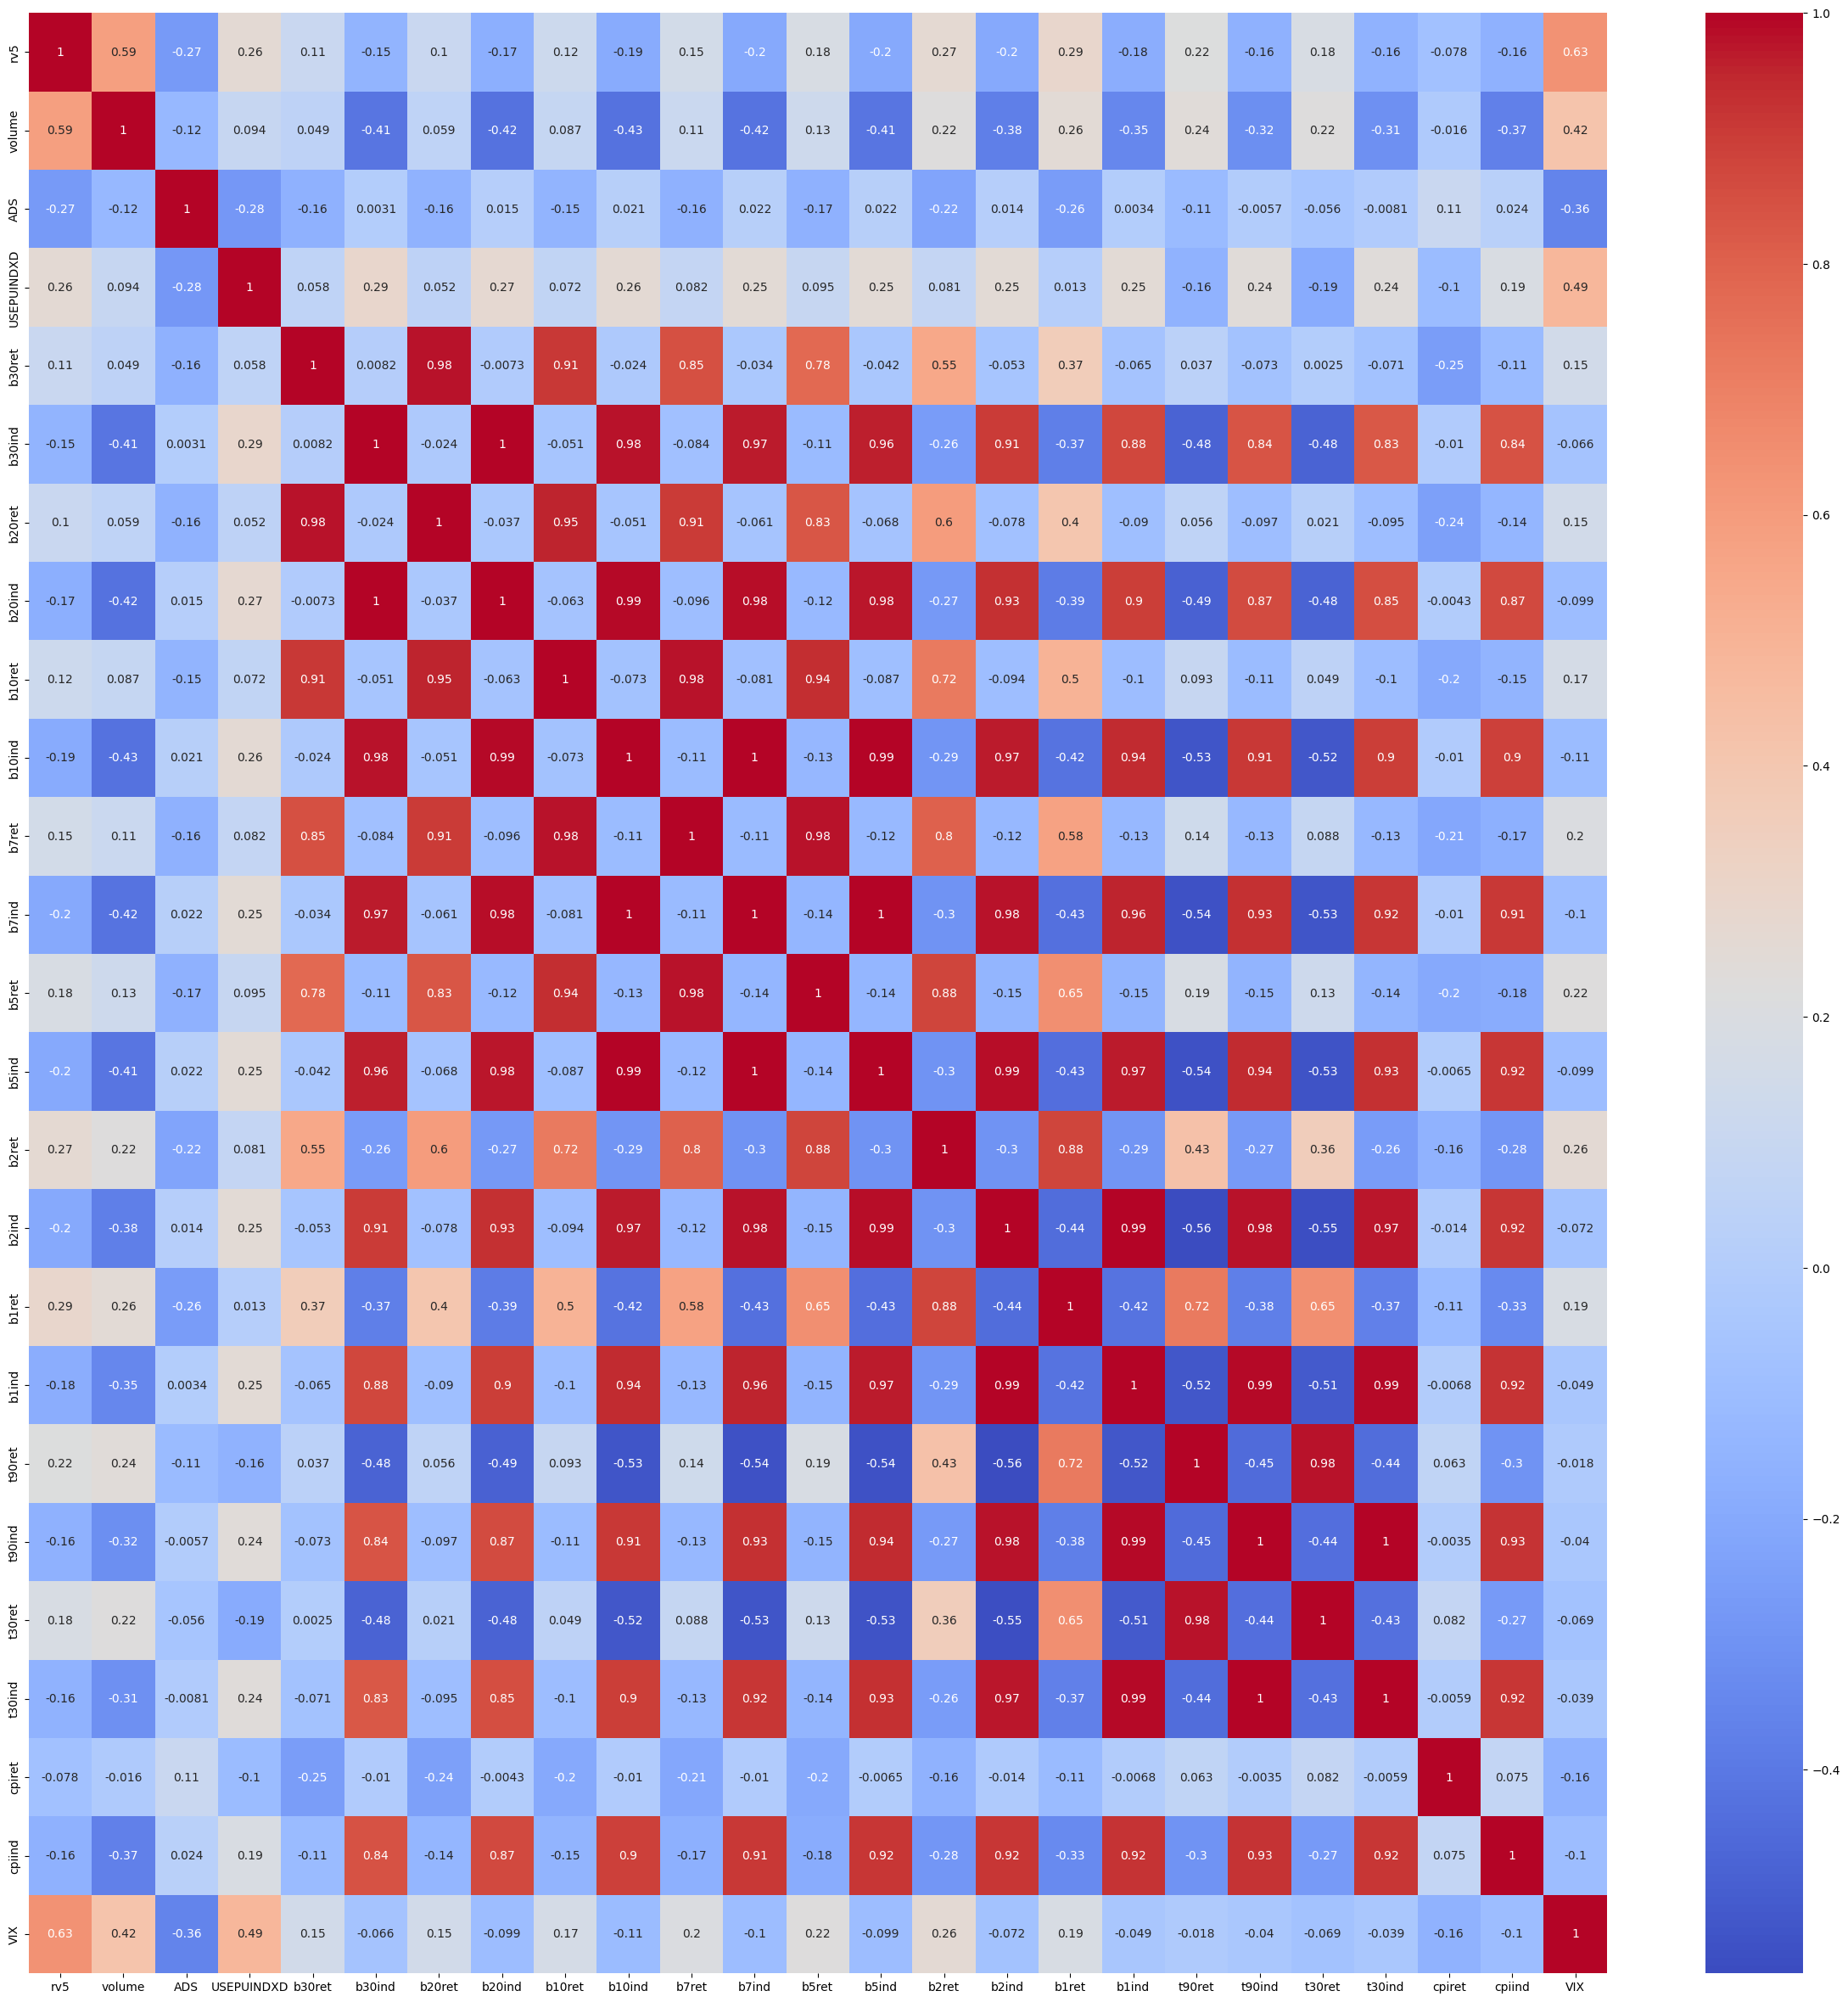

In [101]:
plt.figure(figsize=(30,30))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')

In [104]:
import pandas as pd
import networkx as nx

# Assuming 'data' is your DataFrame
correlation_matrix = data.corr()

# Create a graph from the correlation matrix
graph = nx.Graph()
for i in range(correlation_matrix.shape[0]):
    for j in range(i+1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            graph.add_edge(correlation_matrix.columns[i], correlation_matrix.columns[j])

# Find all cliques in the graph
cliques = list(nx.find_cliques(graph))

# Find the largest clique
largest_clique = max(cliques, key=len)

print(f"The largest group of columns where each pair has a correlation above 0.8 is: {largest_clique}")

The largest group of columns where each pair has a correlation above 0.8 is: ['b7ind', 't90ind', 'b1ind', 'b30ind', 'b20ind', 'b5ind', 'cpiind', 'b10ind', 'b2ind', 't30ind']


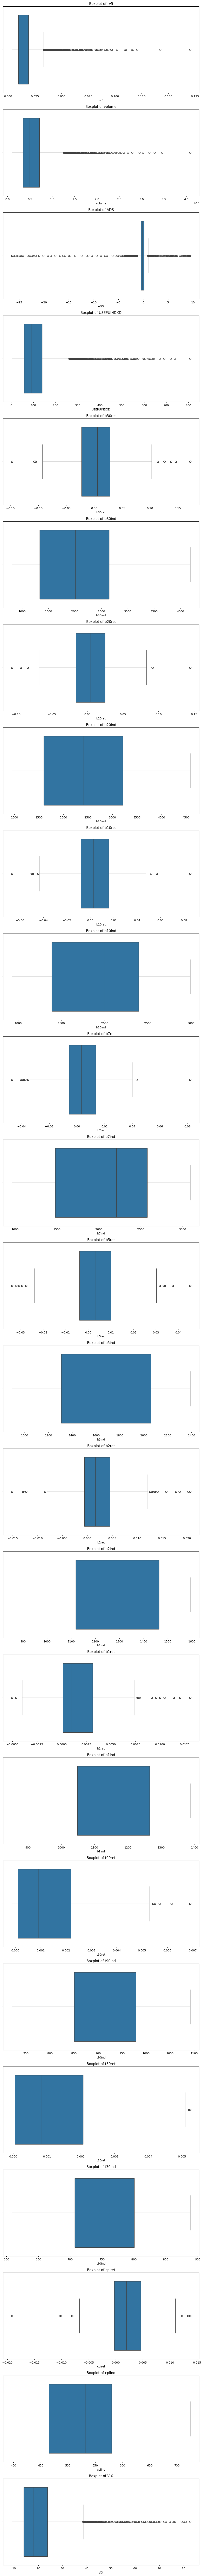

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' is your DataFrame
num_cols = len(data.columns)

# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=num_cols, figsize=(10, num_cols*5))

# Iterate over all columns of the DataFrame and all axes of the subplot grid
for col, ax in zip(data.columns, axes):
    # Create a boxplot for each column
    sns.boxplot(x=data[col], ax=ax)
    ax.set_title(f'Boxplot of {col}')

# Display the figure with all boxplots
plt.tight_layout()
plt.show()

In [ ]:
#TODO: Data Augmentation

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Assuming 'data' is your DataFrame
X = data.drop('rv5', axis=1)
y = data['rv5']

# Perform backward elimination
cols = list(X.columns)
pmax = 1
while (len(cols) > 0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y, X_1).fit()
    p = pd.Series(model.pvalues.values[1:], index=cols)
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if (pmax > 0.05):
        cols.remove(feature_with_p_max)
        print("The feature removed is: ", feature_with_p_max)
    else:
        break

selected_features_BE = cols
print("The significant features after backward elimination are: ", selected_features_BE)
selected_features_BE += ['rv5']
data_selected = data[selected_features_BE]
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Assuming 'data_selected' is your DataFrame and 'rv5' is the column you want to predict
data = data_selected['rv5'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Create a time series dataset
X, y = [], []
for i in range(1, len(data)):
    X.append(data[i - 1:i, 0])
    y.append(data[i, 0])
X, y = np.array(X), np.array(y)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the data to fit the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out


model = LSTMModel(1, 50)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
hist = np.zeros(50)
for t in range(50):
    y_train_pred = model(X_train)
    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

# Make predictions
y_train_pred = model(X_train)
y_test_pred = model(X_test)

# Invert the predictions back to the original scale
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy().reshape(-1, 1))
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy().reshape(-1, 1))

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'Train RMSE: {train_rmse}')
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Test RMSE: {test_rmse}')
train_mae = mean_absolute_error(y_train, y_train_pred)
print(f'Train MAE: {train_mae}')
test_mae = mean_absolute_error(y_test, y_test_pred)
print(f'Test MAE: {test_mae}')

# Plot actual vs predicted values
plt.figure(figsize=(16, 8))
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.legend()
plt.show()

# Plot the training error with each epoch
plt.figure(figsize=(12, 6))
plt.plot(hist, label='Train Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

In [54]:
data = pd.read_csv('MAN_data.csv')

In [55]:
data = data[data['Symbol'] == '.SPX']

In [57]:
# Assuming 'date' is the name of your date column
data['date'] = pd.to_datetime(data['date'])

# Set the date column as the index
data.set_index('date', inplace=True)

C:\Users\Amirmahdi\AppData\Local\Temp\ipykernel_5736\2865369560.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['date'] = pd.to_datetime(data['date'])


In [64]:
import numpy as np

# Calculate the log return
data['log_return'] = np.log(data['return']+1)

In [66]:
data.isna().sum()

Symbol                   0
return                   0
rsv                      0
medrv                    0
rsv_ss                   0
nobs                     0
rv5                      0
close_price              0
realized_volatility      0
open_price               0
predicted_volatility    21
log_return               0
dtype: int64

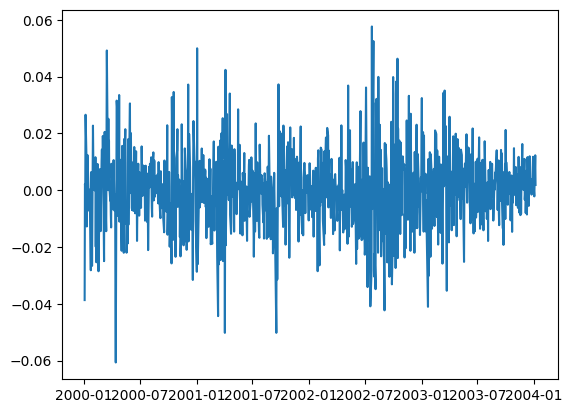

In [63]:
import matplotlib.pyplot as plt

plt.plot(data['log_return'])

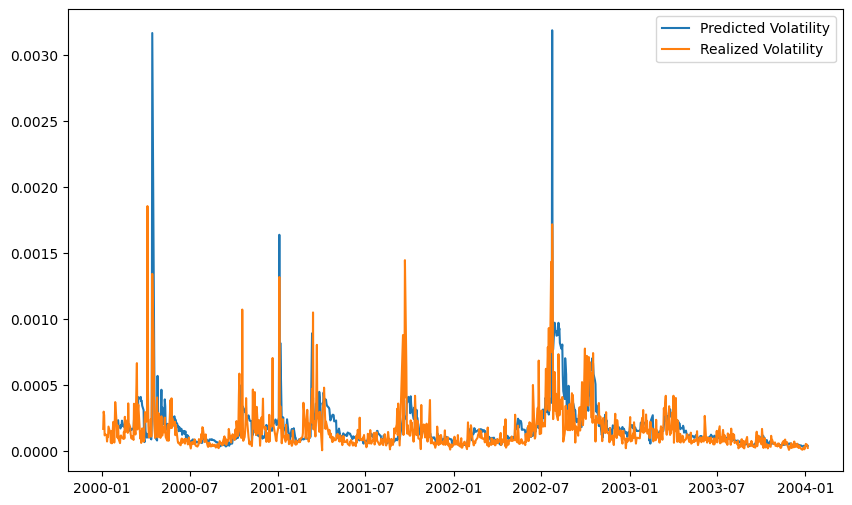

In [59]:

# Select a small fraction of your data
data = data.head(1000)

# Import necessary libraries
from arch import arch_model

# Rename the columns
data = data.rename(columns={'open_to_close': 'return', 'rv10': 'realized_volatility'})

# Define a function to fit the GARCH model and return the forecasted volatility
def predict_volatility(returns):
    model = arch_model(returns, vol='Garch', p=1, q=1, rescale=False)
    model_fit = model.fit(disp='off')
    forecast = model_fit.forecast(start=0)
    return forecast.variance.iloc[-1, 0]

# Apply the function on a rolling basis to the 'return' column
window_size = 22  # Use a rolling window of 22 days (approximately one trading month)
data['predicted_volatility'] = data['return'].rolling(window_size).apply(predict_volatility, raw=True)

# Plot the predicted volatility and the realized volatility
plt.figure(figsize=(10,6))
plt.plot(data['predicted_volatility'], label='Predicted Volatility')
plt.plot(data['realized_volatility'], label='Realized Volatility')
plt.legend()
plt.show()

In [60]:
data.head()

,Symbol,return,rsv,medrv,rsv_ss,nobs,rv5,close_price,realized_volatility,open_price,predicted_volatility
date,,,,,,,,,,,
2000-01-03 00:00:00+00:00,.SPX,-0.011602,0.000096,0.000058,0.000096,1554,0.000141,1454.24,0.000164,1471.21,NaN
2000-01-04 00:00:00+00:00,.SPX,-0.035102,0.000180,0.000067,0.000180,1564,0.000224,1399.02,0.000295,1449.00,NaN
2000-01-05 00:00:00+00:00,.SPX,0.004625,0.000131,0.000142,0.000131,1552,0.000314,1402.09,0.000267,1395.62,NaN
2000-01-06 00:00:00+00:00,.SPX,0.002991,0.000056,0.000070,0.000056,1561,0.000131,1403.06,0.000115,1398.87,NaN
2000-01-07 00:00:00+00:00,.SPX,0.026293,0.000023,0.000049,0.000023,1540,0.000094,1440.84,0.000121,1403.45,NaN
